# 12. Creating a Dataset from numpy arrays
The goal of this notebook is to demonstrate how to create a `DataStore` from scratch. This can be useful if your device is not supported or if you would like to integrate the `dtscalibration` library in your current routine.

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import xarray as xr

from dtscalibration import read_silixa_files
from dtscalibration.dts_accessor import DtsAccessor  # noqa: E402
from dtscalibration.variance_stokes import variance_stokes_constant

For a `DataStore` object, a few things are needed:

- timestamps

- Stokes signal

- anti-Stokes signal

- x (length along fiber)

Let's grab the data from an existing silixa dataset:

In [3]:
filepath = os.path.join("..", "..", "tests", "data", "single_ended")

ds_silixa = read_silixa_files(directory=filepath, silent=True)

We will get all the numpy arrays from this `DataStore` to create a new one from 'scratch'.

Let's start with the most basic data:

In [4]:
x = ds_silixa.x.values
time = ds_silixa.time.values
ST = ds_silixa.st.values
AST = ds_silixa.ast.values

Now this data has to be inserted into an xarray `Dataset`

In [5]:
ds = xr.Dataset()
ds["x"] = ("x", x)
ds["time"] = ("time", time)
ds["st"] = (["x", "time"], ST)
ds["ast"] = (["x", "time"], AST)

In [6]:
print(ds)

<xarray.Dataset>
Dimensions:  (x: 1461, time: 3)
Coordinates:
  * x        (x) float64 -80.74 -80.62 -80.49 -80.36 ... 104.4 104.6 104.7 104.8
  * time     (time) datetime64[ns] 2018-05-04T12:22:17.710000 ... 2018-05-04T...
Data variables:
    st       (x, time) float64 -0.8058 0.4287 -0.513 ... 27.99 27.83 28.81
    ast      (x, time) float64 -0.2459 -0.5932 0.1111 0.3748 ... 36.2 35.7 35.16


For calibration, a few more paramaters are needed:

- acquisition time (for calculating residuals for WLS calibration)

- reference temperatures

- a double ended flag

We'll put these into the custom `DataStore`:

In [7]:
ds["acquisitiontimeFW"] = ds_silixa["acquisitiontimeFW"].values
ds["userAcquisitionTimeFW"] = ds_silixa["acquisitiontimeFW"].values
ds["temp1"] = ds_silixa["probe1Temperature"]
ds["temp2"] = ds_silixa["probe2Temperature"]

ds.attrs["isDoubleEnded"] = "0"

Now we can calibrate the data as usual (ordinary least squares in this example).

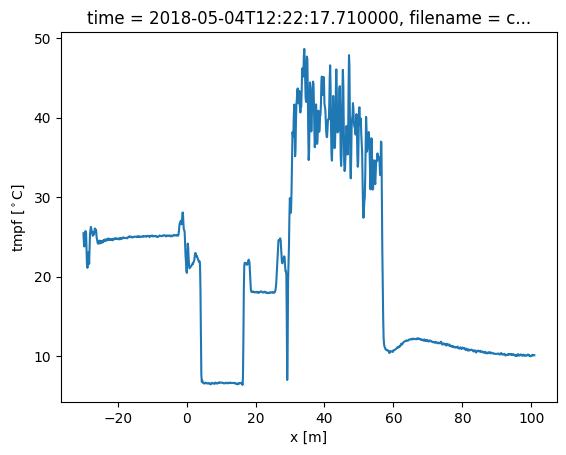

In [9]:
ds = ds.sel(x=slice(-30, 101))
sections = {
    "temp1": [slice(20, 25.5)],  # warm bath
    "temp2": [slice(5.5, 15.5)],  # cold bath
}

st_var, resid = variance_stokes_constant(
    ds.dts.st, sections, ds.dts.acquisitiontime_fw, reshape_residuals=True
)
ast_var, _ = variance_stokes_constant(
    ds.dts.ast, sections, ds.dts.acquisitiontime_fw, reshape_residuals=False
)
out = ds.dts.calibrate_single_ended(sections=sections, st_var=st_var, ast_var=ast_var)
out.isel(time=0).tmpf.plot()